# Initialization & Credentials

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
# The code was removed by Watson Studio for sharing.

# Intro

### Goal

In this music data science project, the overarching goal is to make music recommendations based on identified music taste.

### Motivation

I spend a considerable amount of time relentlessly looking for new songs to fall in love with. While I very much enjoy doing that, I aim to make this process more efficient.
Aside from the recommendations from Spotify via the personalized 'Discover Weekly' & 'Release Radar' playlists, I have been looking into the weekly featured new releases on Allmusic for many years. While the treasure hunt on Allmusic has always been enjoyable and fruitful, it is also very time intensive to go on the website, click on featured albums one by one, read the reviews, find the album and songs on Spotify, listen to the songs one by one, and eventually find a handful of gems among a mountain of songs which I do not enjoy. Therefore, in this project, we will build our personal AI music assistant to help us find music we will like faster.

### Tools

<b>Web scraping</b>: BeautifulSoup, HTML, JSON

<b>Databases</b>: Google Cloud postgreSQL, IBM Cloud Db2, SQL, pandas

<b>API</b>: Spotify API, tekore

<b>Test statistics</b>: SciPy, statsmodels, Q-Q plot, Mann-Whitbey U test, Shapiro-Wilk test, p-value

<b>Machine learning</b>: scikit-learn, NumPy, Hierarchical Clustering Analysis, Euclidian distance, PyTorch

<b>Plots</b>: Matplotlib, Plotly

# Web scraping data from Allmusic

In [9]:
from bs4 import BeautifulSoup
import requests
import json

Let's start by extracting all featured Allmusic albums for a given week.

### Get data from web page

In [10]:
# Choose which week (Friday to Friday) to web scrap
week = "20220114"  # "YYYYMMDD"

In [11]:
# Get web page content
url = f"https://www.allmusic.com/newreleases/{week}"
data = requests.get(url, headers=headers).text
soup = BeautifulSoup(data, "html.parser")

In [12]:
# Get album links
link_ls = []
add = False
for link in soup.find_all('a', href=True):
    if link.get('href') == '/rss':  # fetch links starting from this anchor
        add = True
    if add:
        link_ls.append(link.get('href'))
    if link.get('href') == '/weekly-new-releases-email':  # from this anchor...
        break  # ...stop fetching links
# Extract album links only
album_link_ls = [link for link in link_ls
                 if 'https://www.allmusic.com/album' in link]

In [13]:
# Fetch the JSON data for each album
album_ls = []
for album_link in album_link_ls:  # go through each album link
    data = requests.get(album_link, headers=headers).text
    soup = BeautifulSoup(data, "html.parser")
    result = soup.find('script', type="application/ld+json")  # extract JSON
    album_dct = json.loads(result.contents[0])  # JSON to dct
    album_ls.append(album_dct)  # make list of all album dcts

# Load Allmusic data to Google postgreSQL cloud database

In [14]:
from google.cloud.sql.connector import connector
import sqlalchemy
import pg8000
import pandas as pd

We load the web scraped data to our Google cloud postgreSQL database as a checkpoint for future script runs and as backup in case the data would no longer be available from Allmusic.

### Define functions

Cloud SQL Python Connector function to get connection & engine objects:

In [15]:
def init_connection_engine() -> sqlalchemy.engine.Engine:

    def getconn() -> pg8000.dbapi.Connection:
        conn: pg8000.dbapi.Connection = connector.connect(
            google_credentials["host"],
            "pg8000",
            user=google_credentials["user"],
            password=google_credentials["pwd"],
            db=google_credentials["db"],
        )
        return conn

    engine = sqlalchemy.create_engine(
        "postgresql+pg8000://",
        creator=getconn,
    )
    engine.dialect.description_encoding = None
    return engine, getconn()

Function to carry out SQL queries:

In [16]:
def exec_sql(sql_query: str):
    db_engine, db_conn = init_connection_engine()  # connect to database
    curr = db_conn.cursor()  # create cursor
    curr.execute(sql_query)  # execute sql query
    db_conn.commit()  # commit request
    db_conn.close()  # close connection

### Create new database table

In [17]:
# SQL string to create table in which we will then load the Allmusic data
sql_str = f"""CREATE TABLE allmusic_{week} (
    album_name text, type text, album_url text, image_url text, reviewer text,
    genre jsonb, artist jsonb,
    date_published date,
    PRIMARY KEY (album_name, date_published)
);"""
exec_sql(sql_str)

In [18]:
# Check the created empty table using pandas SQL function
db_engine, db_conn = init_connection_engine()  # connect to database
pd.read_sql(f"SELECT * FROM allmusic_{week}", db_engine)

,album_name,type,album_url,image_url,reviewer,genre,artist,date_published


### Load data to database table

In [19]:
# Loop to load Allmusic album data to rows in the created GC postgreSQL table
for ialbum in album_ls:

    if ialbum['@type'] == 'MusicAlbum':  # dct structure depends on type
        sql_str = f"""INSERT INTO allmusic_{week} (
            album_name, type, album_url, date_published,
            image_url, reviewer, genre, artist
        )
        VALUES (
            '{ialbum["name"].replace("'", "")}', '{ialbum["@type"]}',
            '{ialbum["url"]}', '{ialbum["datePublished"]}',
            '{ialbum["image"]}', '{ialbum["review"]["author"]["name"]}',
            '{json.dumps(ialbum["genre"])}',
            '{json.dumps(ialbum["byArtist"]).replace("'", "")}'
        )"""

    if ialbum["@type"] == "MusicRelease":  # dct structure depends on type
        sql_str = f"""INSERT INTO allmusic_{week} (
            album_name, type, album_url, date_published,
            image_url, genre, artist
        )
        VALUES (
            '{ialbum["name"].replace("'", "")}', '{ialbum["@type"]}',
            '{ialbum["url"]}', '{ialbum["datePublished"]}',
            '{ialbum["image"]}', '{json.dumps(ialbum["genre"])}',
            '{json.dumps(ialbum["releaseOf"]["byArtist"])}'
        )"""

    exec_sql(sql_str)

In [20]:
# Check the data loaded to the database table using pandas SQL function
pd.read_sql(f"SELECT * FROM allmusic_{week}", db_engine).head()

,album_name,type,album_url,image_url,reviewer,genre,artist,date_published
0,The Boy Named If,MusicAlbum,https://www.allmusic.com/album/the-boy-named-i...,https://rovimusic.rovicorp.com/image.jpg?c=ETt...,Stephen Thomas Erlewine,[Pop/Rock],[{'url': 'https://www.allmusic.com/artist/elvi...,2022-01-14
1,Covers,MusicAlbum,https://www.allmusic.com/album/covers-mw000361...,https://rovimusic.rovicorp.com/image.jpg?c=pPX...,Heather Phares,[Pop/Rock],[{'url': 'https://www.allmusic.com/artist/cat-...,2022-01-14
2,Brightside,MusicAlbum,https://www.allmusic.com/album/brightside-mw00...,https://rovimusic.rovicorp.com/image.jpg?c=7BR...,Timothy Monger,"[Pop/Rock, Folk]",[{'url': 'https://www.allmusic.com/artist/the-...,2022-01-14
3,Dodging Dues,MusicAlbum,https://www.allmusic.com/album/dodging-dues-mw...,https://rovimusic.rovicorp.com/image.jpg?c=BzJ...,Fred Thomas,[Pop/Rock],[{'url': 'https://www.allmusic.com/artist/garc...,2022-01-14
4,Dawn FM,MusicAlbum,https://www.allmusic.com/album/dawn-fm-mw00036...,https://rovimusic.rovicorp.com/image.jpg?c=JE0...,Andy Kellman,[R&amp;B],[{'url': 'https://www.allmusic.com/artist/the-...,2022-01-07


### Fetch data from database table

We fetch the relevant data back from our Google cloud postgreSQL database. 

Remark: This is an entry point to the notebook the web scraping part was previously already run.

In [21]:
# Fetch info for music albums which are not of purely classical genre
allmusic_df = pd.read_sql(
    f"""SELECT album_name, artist FROM allmusic_{week}
    WHERE type = 'MusicAlbum' AND genre != '["Classical"]';""",
    db_engine
)

In [22]:
# Check fetched df
allmusic_df.head()

,album_name,artist
0,The Boy Named If,[{'url': 'https://www.allmusic.com/artist/elvi...
1,Covers,[{'url': 'https://www.allmusic.com/artist/cat-...
2,Brightside,[{'url': 'https://www.allmusic.com/artist/the-...
3,Dodging Dues,[{'url': 'https://www.allmusic.com/artist/garc...
4,Dawn FM,[{'url': 'https://www.allmusic.com/artist/the-...


# Add Allmusic tracks to new Spotify playlist

### Connect to Spotify API

In [23]:
# Connect to Spotify API using the tekore library
app_token = tk.request_client_token(
    spotify_credentials['client_id'],
    spotify_credentials['client_secret']
)
spotify = tk.Spotify(app_token)
spotify.token = user_token

### Find Allmusic album tracks on Spotify

In [24]:
track_uri_ls = []

for index, row in allmusic_df.iterrows():  # go through all rows of the df
    # Extract all artist names from list of dcts
    artist_ls = [idct["name"].replace("&amp;", "&")
                 for idct in allmusic_df.loc[index, 'artist']]
    # Replace list of dcts with list of artist names
    allmusic_df.at[index, 'artist'] = artist_ls
    # Generate Spotify search string from album & artist names
    search_str = (f"{allmusic_df.loc[index, 'album_name']} " +
                  " ".join([istr for istr in artist_ls]))
    # Try to find each album on Spotify, extract album id & track uris
    try:
        album_search = spotify.search(
            search_str,
            types=('album',),
            limit=1
        )
        album_id = album_search[0].items[0].id
        allmusic_df.loc[index, 'album_id'] = album_id  # add album id to df
        # Inform user of album search success
        print((f"{index} album id '{album_id}' "
               f"for Spotify search '{search_str}'"))
        album_tk = spotify.album(album_id)  # get album from Spotify
        # Generate list with Spotify track uris
        track_uri_ls.append([itrack.uri for itrack in album_tk.tracks.items])
    # Inform user in case an album search fails
    except (KeyError, IndexError):
        print((f"! Failed to retrieve album id "
               f"for Spotify search '{search_str}'"))
        pass  # go to next album search

! Failed to retrieve album id for Spotify search 'The Boy Named If Elvis Costello Elvis Costello & the Imposters'
1 album id '58z5GjZRjt6XIz5GOS0PJh' for Spotify search 'Covers Cat Power'
2 album id '5Vb119mjQekK46CfEWDQXW' for Spotify search 'Brightside The Lumineers'
3 album id '0rCxFVuVQ1wC703w386nCb' for Spotify search 'Dodging Dues Garcia Peoples'
4 album id '2nLOHgzXzwFEpl62zAgCEC' for Spotify search 'Dawn FM The Weeknd'
5 album id '7fZYAQ9HtGNemdpr8xt3SP' for Spotify search 'Collected Pieces: 2015-2020 Mary Lattimore'
6 album id '0NFcvZO9xMAnYhPn3sfhBp' for Spotify search 'Toy (Toy:Box) David Bowie'
7 album id '2kTRQdoZgmxMtTD17vyVNU' for Spotify search 'Extreme Molly Nilsson'
8 album id '51heTwkSfb4Z5dRIgwU2bd' for Spotify search 'Sick! Earl Sweatshirt'
9 album id '3J9a9IUBPJL3WhkC86mCw1' for Spotify search 'Fix Yourself, Not the World The Wombats'
10 album id '6uv3nIiip5lAAG41OQIk0f' for Spotify search 'Voyeurist Underoath'
11 album id '5XptR8Eatr8J2KlcO7heEA' for Spotify sear

### Create Spotify playlist from Allmusic albums

In [25]:
# Create new Spotify playlist & add Allmusic album tracks to it
user = spotify.current_user()

playlist = spotify.playlist_create(
    user.id,
    f"Allmusic {week}",  # playlist name
    public=False,
    description=f"Allmusic's featured albums of week {week}."
)

for iuri_ls in track_uri_ls:  # add tracks one by one from their Spotify uris
    spotify.playlist_add(playlist.id, uris=iuri_ls)

# Fetch Spotify data

In [26]:
from datetime import date
from typing import List
import time

### Define functions

Function to add song audio features to track dataframe:

In [27]:
def add_song_features(
    song_df: pd.core.frame.DataFrame
) -> pd.core.frame.DataFrame:

    for song_id in song_df["song_id"]:  # get audio features track by track
        row = (song_df.loc[:, "song_id"] == song_id)
        ftr_not_yet_retrieved = True
        nr_of_fails = 0

        while ftr_not_yet_retrieved:

            try:
                ftr = spotify.track_audio_features(song_id)  # fails sometimes
                ftr_not_yet_retrieved = False

                if ftr != [None]:
                    song_df.loc[row, "instrumentalness"] = ftr.instrumentalness
                    song_df.loc[row, "time_signature"] = ftr.time_signature
                    song_df.loc[row, "danceability"] = ftr.danceability
                    song_df.loc[row, "acousticness"] = ftr.acousticness
                    song_df.loc[row, "speechiness"] = ftr.speechiness
                    song_df.loc[row, "loudness"] = ftr.loudness
                    song_df.loc[row, "liveness"] = ftr.liveness
                    song_df.loc[row, "valence"] = ftr.valence
                    song_df.loc[row, "energy"] = ftr.energy
                    song_df.loc[row, "tempo"] = ftr.tempo
                    song_df.loc[row, "mode"] = ftr.mode
                    song_df.loc[row, "key"] = ftr.key

            except TypeError:
                ftr_not_yet_retrieved = True
                nr_of_fails += 1
                print(("Couldn't retrieve audio features for song '"
                       f"{song_df.loc[row, 'song_name'].values[0]}'."))

                if nr_of_fails < 3:
                    print('Retrying.')
                    time.sleep(1)  # time delay to deal with API rate limit

                else:
                    print('Moving on to next track.')
                    break

    return song_df

Function to get from a list of tracks a dataframe of the songs & their info:

In [28]:
def playlist_to_df(track_ls: list) -> pd.core.frame.DataFrame:

    # Initialize lists to store respective data
    release_date_ls = []
    artist_name_ls = []
    duration_ms_ls = []
    popularity_ls = []
    song_name_ls = []
    song_uri_ls = []
    explicit_ls = []
    song_id_ls = []

    for itk in track_ls:

        if itk.type != 'track':
            continue

        release_date_ls.append(itk.album.release_date)
        artist_name_ls.append(itk.artists[0].name)
        duration_ms_ls.append(itk.duration_ms)
        popularity_ls.append(itk.popularity)
        explicit_ls.append(itk.explicit)
        song_name_ls.append(itk.name)
        song_uri_ls.append(itk.uri)
        song_id_ls.append(itk.id)

    # Make a dct from lists iteratively defined above
    song_dct = {
        "release_date": release_date_ls,
        "duration_ms": duration_ms_ls,
        "artist_name": artist_name_ls,
        "popularity": popularity_ls,
        "song_name": song_name_ls,
        "explicit": explicit_ls,
        "song_uri": song_uri_ls,
        "song_id": song_id_ls
    }
    # Build df from dct
    song_df = pd.DataFrame(song_dct)
    # Convert T/F to 1/0
    song_df['explicit'] = song_df['explicit'].astype(int)

    return song_df

Function to find playlist & fetch its tracks incl. info & features using above defined sub-functions:

In [29]:
def find_fetch_playlist(playlist_str: str) -> (str, pd.core.frame.DataFrame):

    playlist_search = spotify.search(
        playlist_str, types=('playlist',),
        limit=2
    )
    playlist_tk = playlist_search[0].items[0]

    if playlist_tk.name != playlist_str:  # use 2nd result if 1st not correct
        playlist_tk = playlist_search[0].items[1]

    print(("Fetching tracks incl. info & audio features "
           f"from the playlist '{playlist_tk.name}'"))

    first_items = spotify.playlist_items(playlist_tk.id)
    track_ls = []

    for item in spotify.all_items(first_items):
        track_ls.append(item.track)

    # Use list comprehension to make list of lists to deal w/ Spotify API limit
    track_ls = [track_ls[x:x+50] for x in range(0, len(track_ls), 50)]
    df_ls = []
    # Chunk-wise fetching of audio features to build df
    for track_ils in track_ls:
        song_df = playlist_to_df(track_ils)  # use fn to build df
        time.sleep(3)  # delay to deal with API rate limit
        song_df = add_song_features(song_df)  # use fn to add audio ftrs to df
        df_ls.append(song_df)  # iteratively add dfs to list
        song_df = pd.concat(df_ls, ignore_index=True)
        time.sleep(3)  # delay to deal with API rate limit

    return playlist_tk.name, song_df

### Fetch playlist tracks incl. info & features

In [30]:
# Specify names of playlists to fetch
playlist_ls = ["Your Top Songs 2021",
               "Your Top Songs 2020",
               "Your Top Songs 2019",
               f"Allmusic {week}",
               "Today's Top Hits"]

In [32]:
# Build dct of playlists with their tracks, info, features and stats
playlist_dct = {}
for iplaylist in playlist_ls:  # fetch all playlists specified in above list
    playlist_name, song_df = find_fetch_playlist(iplaylist)
    playlist_dct[playlist_name] = {}  # initialize sub-dct for each playlist
    playlist_dct[playlist_name]["data_df"] = song_df
    playlist_dct[playlist_name]["stats_df"] = song_df.describe()
    if playlist_name == "Today's Top Hits":  # time-dependent playlist
        today_str = str(date.today())
        playlist_dct[playlist_name]["data_df"]["date_added"] = today_str
    time.sleep(1)  # delay because of API rate limit

Fetching tracks incl. info & audio features from the playlist 'Your Top Songs 2021'
Fetching tracks incl. info & audio features from the playlist 'Your Top Songs 2020'
Fetching tracks incl. info & audio features from the playlist 'Your Top Songs 2019'
Fetching tracks incl. info & audio features from the playlist 'Allmusic 20220114'
Fetching tracks incl. info & audio features from the playlist 'Today's Top Hits'


# Load/fetch Spotify data to/from IBM Db2 cloud database

In [33]:
from sqlalchemy.engine import create_engine

We load all data to our IBM Cloud Db2 database as a checkpoint for future script runs, so to quickly get the prepared data from our database instead of re-fetching all data via the Spotify API.

### Connect to database

In [34]:
db_conn_str = (f"ibm_db_sa://{ibm_credentials['user']}:"
               f"{ibm_credentials['pwd']}@{ibm_credentials['host']}:"
               f"{ibm_credentials['port']}/{ibm_credentials['db']}?"
               f"security={ibm_credentials['security']}")
db_engine = create_engine(db_conn_str)

### Load data to database

In [35]:
sql_query = f"SELECT date_added FROM todays_top_hits"
last_db_date = pd.read_sql(sql_query, db_engine).iloc[-1, :].values[0]

for iplaylist in playlist_dct.keys():

    itable_name = iplaylist.replace(" ", "_").replace("'", "").lower()

    if (iplaylist == "Today's Top Hits") and (last_db_date != today_str):
        print((f"Loading playlist '{iplaylist}' data"
               f" to '{itable_name}' database table."))
        todays_top_hits_df = playlist_dct[iplaylist]["data_df"].copy()
        todays_top_hits_df.to_sql(
            itable_name,
            con=db_engine,
            if_exists="append"
        )  # my db table for this playlist was already initialized

    if iplaylist != "Today's Top Hits":
        print((f"Loading playlist '{iplaylist}' data"
               f" to '{itable_name}' database table."))
        playlist_dct[iplaylist]["data_df"].to_sql(
            itable_name,
            con=db_engine,
            if_exists="replace"
        )

Loading playlist 'Your Top Songs 2021' data to 'your_top_songs_2021' database table.
Loading playlist 'Your Top Songs 2020' data to 'your_top_songs_2020' database table.
Loading playlist 'Your Top Songs 2019' data to 'your_top_songs_2019' database table.
Loading playlist 'Allmusic 20220114' data to 'allmusic_20220114' database table.
Loading playlist 'Today's Top Hits' data to 'todays_top_hits' database table.


### Fetch data from database

Remark: Notebook entry point data already previously gathered and loaded to database.

In [36]:
playlist_dct = {}

for iplaylist in playlist_ls:
    itable_name = iplaylist.replace(" ", "_").replace("'", "").lower()
    sql_query = f"SELECT * FROM {itable_name}"
    idf = pd.read_sql(sql_query, db_engine, index_col='index')
    playlist_dct[iplaylist] = {}
    playlist_dct[iplaylist]['data_df'] = idf
    playlist_dct[iplaylist]['stats_df'] = idf.describe()
print(f"Playlists fetched from database:\n{list(playlist_dct.keys())}")

Playlists fetched from database:
['Your Top Songs 2021', 'Your Top Songs 2020', 'Your Top Songs 2019', 'Allmusic 20220114', "Today's Top Hits"]


# My most listened artists & genres of 2020-2021

We are now ready to start getting some insights into our top songs.

Before diving straight into music analysis that will inform our recommendations, let's first have a general look at our top songs and create visuals inspired from the 'Spotify Wrapped' experience.

In [37]:
artist_all_ls = []
genre_all_ls = []
# Here, we will only look at our top songs from the Covid-19 pandemic yrs
playlist_ls = ['Your Top Songs 2021', 'Your Top Songs 2020']

for iplaylist in playlist_ls:

    artist_ls = [spotify.track(songid).artists[0]
                 for songid in playlist_dct[iplaylist]['data_df']['song_id']]
    artist_id_ls = [iartist.id for iartist in artist_ls]
    artist_name_ls = [iartist.name for iartist in artist_ls]
    time.sleep(8)  # delay to deal with API rate limit
    artist_tk_ls = [spotify.artist(artist_id) for artist_id in artist_id_ls]
    genre_ls = [list(artist_tk.genres) for artist_tk in artist_tk_ls]
    genre_ls = [igenre for sublist in genre_ls for igenre in sublist]
    artist_all_ls.extend(artist_name_ls)
    genre_all_ls.extend(genre_ls)
    playlist_dct[iplaylist]['artists'] = {x: artist_name_ls.count(x)
                                          for x in artist_name_ls}
    playlist_dct[iplaylist]['genres'] = {x: genre_ls.count(x)
                                         for x in genre_ls}
    time.sleep(8)  # delay to deal with API rate limit

playlist_dct['Your Top Songs 2020-2021'] = {}
# dct comprehension to get artist count
playlist_dct['Your Top Songs 2020-2021']['artists_all'] = \
    {x: artist_all_ls.count(x) for x in artist_all_ls}
# dct comprehension to get genre count
playlist_dct['Your Top Songs 2020-2021']['genres_all'] = \
    {x: genre_all_ls.count(x) for x in genre_all_ls}
# Sort artists from most to least counts
artists_sorted = sorted(
    playlist_dct['Your Top Songs 2020-2021']['artists_all'],
    key=playlist_dct['Your Top Songs 2020-2021']['artists_all'].get,
    reverse=True
)
playlist_dct['Your Top Songs 2020-2021']['artists_top'] = artists_sorted[:15]
# Sort genres from most to least counts
genres_sorted = sorted(
    playlist_dct['Your Top Songs 2020-2021']['genres_all'],
    key=playlist_dct['Your Top Songs 2020-2021']['genres_all'].get,
    reverse=True
)
playlist_dct['Your Top Songs 2020-2021']['genres_top'] = genres_sorted[:15]

In [38]:
print(("My top artists of 2020-2021: \n"
       f"{playlist_dct['Your Top Songs 2020-2021']['artists_top']}"))

My top artists of 2020-2021: 
['Apashe', 'Derek Pope', 'Rilès', 'Glass Animals', 'BRONSON', 'Dua Saleh', 'Jelani Aryeh', 'Albi X', 'KUNZITE', 'ufo ufo', 'ODESZA', '070 Shake', 'Halsey', 'Raissa', 'SG Lewis']


In [39]:
print(("My top genres of 2020-2021: \n"
       f"{playlist_dct['Your Top Songs 2020-2021']['genres_top']}"))

My top genres of 2020-2021: 
['alternative r&b', 'bass trap', 'modern rock', 'pop', 'rock', 'electropop', 'modern alternative rock', 'dance pop', 'edm', 'escape room', 'indie r&b', 'indie soul', 'indie poptimism', 'vapor soul', 'vapor twitch']


### 'Spotify Wrapped'-inspired visuals for my top artist & genres of 2020-2021:

For the genres, we condense our top 12 genres to 5 genre groups, e.g. we group 'escape room' with 'indie soul', as these genres are relatively close:
https://everynoise.com/engenremap-escaperoom.html

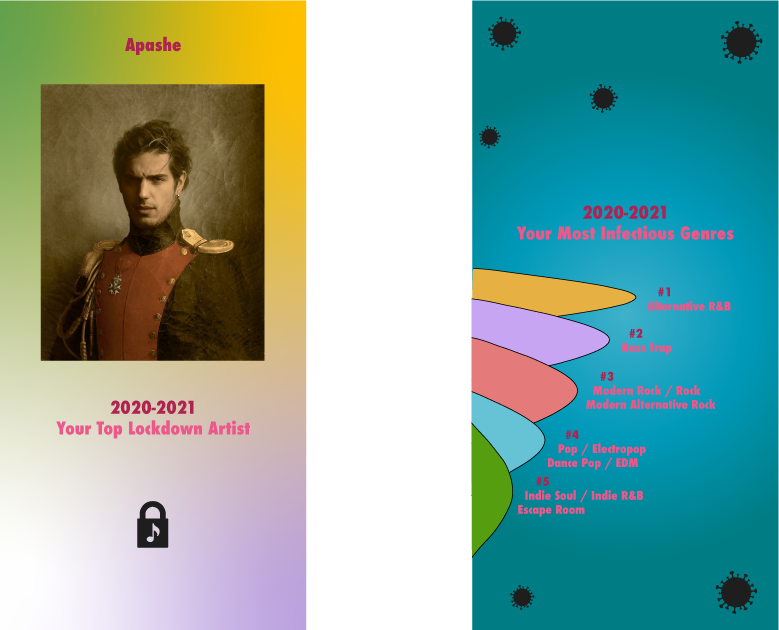

Can these early insights be beneficial for the recommendation system we want to build later down this notebook? Well, regarding my top artist Apashe, as prolific as he is, he is not going to release an album every week, so no need to specifically look for songs from him every week in the Allmusic featured albums. Regarding my top genres, we could give them higher scoring in our recommendation system, but... we are not going to. Genres are constantly evolving and so are my preferences. Let's have a look at how my preferences varied from just one year to the other:

In [40]:
genres_2021_sorted = sorted(
    playlist_dct['Your Top Songs 2021']['genres'],
    key=playlist_dct['Your Top Songs 2021']['genres'].get,
    reverse=True
)
top_genres_2021 = genres_2021_sorted[:15]
genres_2020_sorted = sorted(
    playlist_dct['Your Top Songs 2020']['genres'],
    key=playlist_dct['Your Top Songs 2020']['genres'].get,
    reverse=True
)
top_genres_2020 = genres_2020_sorted[:15]
print(f"My top genres of 2021:\n{top_genres_2021}\n")
print(f"My top genres of 2020:\n{top_genres_2020}")

My top genres of 2021:
['alternative r&b', 'indie soul', 'vapor soul', 'pop', 'bass trap', 'vapor twitch', 'edm', 'trap soul', 'indie r&b', 'electropop', 'escape room', 'indietronica', 'indie pop', 'modern alternative rock', 'modern rock']

My top genres of 2020:
['bass trap', 'modern rock', 'rock', 'alternative r&b', 'electropop', 'indie poptimism', 'modern alternative rock', 'hip hop', 'dance pop', 'pop', 'escape room', 'alternative hip hop', 'indie r&b', 'rap', 'edm']


In 2021 I was fond of genres like 'vapor soul', 'vapor twitch' and 'trap soul', whereas in 2020 these genres were not anywhere to be found in my top 15. 

My top genre is currently Alternative R&B. Here's what the great Frank Ocean had to say when asked if he considers his song "Novacane" to be an R&B song: "You're limiting it. And that's why I always say that about the genre thing, because that's what it does. When you say 'it's that', you listen to it in a certain way."

Let's not limit ourselves nor our AI music assistant.

# Comparing my current music taste to the world

Let's explore my musical taste by starting with a comparison with the current global top hits.

In [41]:
from scipy.stats import shapiro, mannwhitneyu
import statsmodels.api as sm
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import pylab as py
import psutil
from IPython.display import Image

### My top 2019-2021 songs

In [42]:
# We put together my top songs from the last 3 yrs...
# ...& use this set to explore my musical preferences
playlist_dct["Your Top Songs 2019-2021"] = {}
playlist_dct["Your Top Songs 2019-2021"]["data_df"] = pd.concat(
    [playlist_dct["Your Top Songs 2021"]["data_df"],
     playlist_dct["Your Top Songs 2020"]["data_df"],
     playlist_dct["Your Top Songs 2019"]["data_df"]]
)
playlist_dct["Your Top Songs 2019-2021"]["data_df"].drop_duplicates(
    subset='song_name',
    inplace=True
)
playlist_dct["Your Top Songs 2019-2021"]["stats_df"] = \
    playlist_dct["Your Top Songs 2019-2021"]["data_df"].describe()
# Quick look at some stats regarding the audio features of my top songs
playlist_dct["Your Top Songs 2019-2021"]["stats_df"]

,duration_ms,popularity,explicit,instrumentalness,time_signature,danceability,acousticness,speechiness,loudness,liveness,valence,energy,tempo,mode,key
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,218536.494662,35.558719,0.298932,0.125646,3.964413,0.639964,0.144153,0.082669,-6.387648,0.172630,0.481530,0.729164,121.046512,0.412811,5.594306
std,47058.514173,21.719912,0.458607,0.254147,0.302632,0.137323,0.186335,0.073201,2.151742,0.111332,0.221718,0.142151,23.859444,0.493218,3.580578
min,102152.000000,0.000000,0.000000,0.000000,1.000000,0.176000,0.000003,0.025400,-12.709000,0.038200,0.039200,0.265000,72.608000,0.000000,0.000000
25%,188108.000000,21.000000,0.000000,0.000004,4.000000,0.556000,0.016800,0.036800,-7.818000,0.102000,0.300000,0.626000,103.000000,0.000000,2.000000
50%,213866.000000,40.000000,0.000000,0.000618,4.000000,0.649000,0.066100,0.052600,-6.286000,0.125000,0.490000,0.749000,120.005000,0.000000,6.000000
75%,243010.000000,51.000000,1.000000,0.070400,4.000000,0.734000,0.189000,0.091900,-4.792000,0.213000,0.643000,0.847000,134.997000,1.000000,9.000000
max,438267.000000,80.000000,1.000000,0.943000,5.000000,0.943000,0.879000,0.375000,-1.545000,0.675000,0.966000,0.991000,188.010000,1.000000,11.000000


This simple statistics table shows that, on average, I like music with high energy (>0.7), wheras the valence (~happiness) is overall well balanced around ~0.5.

### Today's top hits

In [43]:
playlist_dct["Today's Top Hits"]["data_df"].drop_duplicates(
    subset='song_name',
    inplace=True
)
playlist_dct["Today's Top Hits"]["stats_df"] = \
    playlist_dct["Today's Top Hits"]["data_df"].describe()
# Let's see how the the stats of the current global hits look like
playlist_dct["Today's Top Hits"]["stats_df"]

,duration_ms,explicit,popularity,danceability,valence,energy,instrumentalness,key,loudness,speechiness,mode,acousticness,liveness,tempo,time_signature
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,196267.333333,0.507937,86.603175,0.673286,0.512638,0.634698,0.001245,5.000000,-6.207476,0.093887,0.571429,0.230754,0.163754,122.281937,3.920635
std,61907.269481,0.503953,11.643273,0.126850,0.232388,0.152574,0.006909,3.971674,2.017711,0.079983,0.498847,0.228230,0.112207,30.677044,0.450863
min,136266.000000,0.000000,34.000000,0.308000,0.038600,0.286000,0.000000,0.000000,-11.881000,0.028200,0.000000,0.001800,0.026400,72.993000,1.000000
25%,163749.000000,0.000000,85.000000,0.603000,0.397500,0.525000,0.000000,1.000000,-7.319500,0.042700,0.000000,0.041700,0.091650,96.004500,4.000000
50%,189727.000000,1.000000,90.000000,0.690000,0.511000,0.669000,0.000000,5.000000,-6.118000,0.053000,1.000000,0.170000,0.117000,121.963000,4.000000
75%,211780.000000,1.000000,93.000000,0.761500,0.687500,0.763500,0.000070,8.000000,-4.611000,0.108000,1.000000,0.360500,0.189000,140.523000,4.000000
max,613026.000000,1.000000,100.000000,0.956000,0.942000,0.897000,0.054200,11.000000,-2.724000,0.363000,1.000000,0.946000,0.461000,184.009000,5.000000


We see that the global hits, on average, have a high danceability (~0.7), and that the valence is overall well balanced around ~0.5.

We also see that 50% of the songs are explicit and that the instrumentalness is ~0, even for the song with the highest instrumentalness (0.05).

### Plot

Perhaps simpler and more appealing than comparing two tables, let's make a comparative interactive plot.

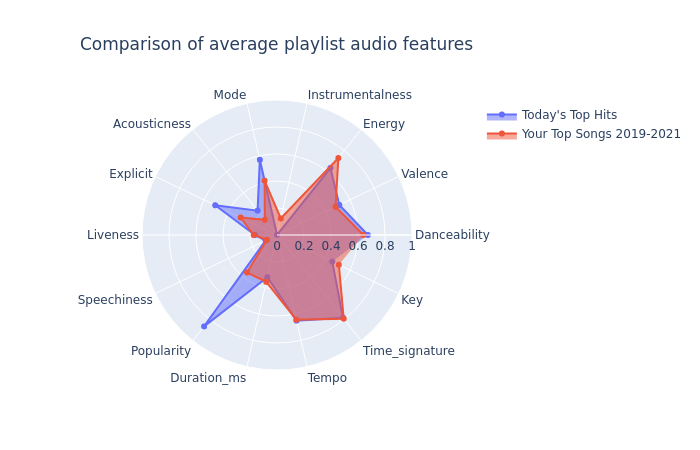

In [44]:
# Plot radar chart
fig = go.Figure()
data = []
feature_avg = {}

playlists_select = ["Today's Top Hits", "Your Top Songs 2019-2021"]
feature_norm1_ls = ["danceability", "valence", "energy",
                    "instrumentalness", "mode", "acousticness",
                    "explicit", "liveness", "speechiness"]
feature_tonorm_ls = ["popularity", "duration_ms", "tempo",
                     "time_signature", "key"]
feature_ls = feature_norm1_ls + feature_tonorm_ls


feature_max_df = pd.DataFrame(
    [playlist_dct["Today's Top Hits"]["stats_df"].loc['max', :],
     playlist_dct["Your Top Songs 2019-2021"]["stats_df"].loc['max', :]]
)
feature_max = feature_max_df.max()

for iplaylist in playlists_select:

    feature_avg[iplaylist] = playlist_dct[iplaylist]['stats_df'].loc['mean', :]

    r_ls = [feature_avg[iplaylist][ifeature] for ifeature in feature_norm1_ls]
    r_ls.extend([feature_avg[iplaylist][ifeature]/feature_max[ifeature]
                 for ifeature in feature_tonorm_ls])

    theta_ls = [ifeature.capitalize() for ifeature in feature_ls]
    theta_ls.append(theta_ls[0])

    fig.add_trace(go.Scatterpolar(
        r=r_ls,
        theta=theta_ls,
        fill='toself',
        name=iplaylist
    ))

fig.update_layout(
    title=go.layout.Title(
        text='Comparison of average playlist audio features',
        xref='paper',
        x=0
    ),
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    showlegend=True,
)

# Static version of the radar chart
fig.show("png")

The interactive version of the chart can be found here:

https://aurelianjh.github.io/allmusic-spotify/

To add to the observations made from the tables above, we notice from this radar chart that I seem to slightly prefer songs composed in minor keys (0) and that global hits seem to have a preference for major keys (1).
In the words of the music composer and teacher Frederick Corder, a "slight sense of mystery and strangeness is conveyed by the Tonic minor chord". Mystery and strangeness certainly sounds appealing to me.

Other observations we can make is that on average global hits seem to be composed in slightly lower keys and are slightly shorter than my top songs, and I seem to prefer songs that are slightly less acoustic than the average global hit. But which of these feature preferences are truly significant? Comparing average values that are close to one another does not allow us to infer robust conclusions. Instead, we will turn to more rigorous statistic tests in the next part.

### Find significant features

To figure out what statistic test to use, we need to know if our features have a normal distribution. We can do that by looking at Q-Q plots for each feature.

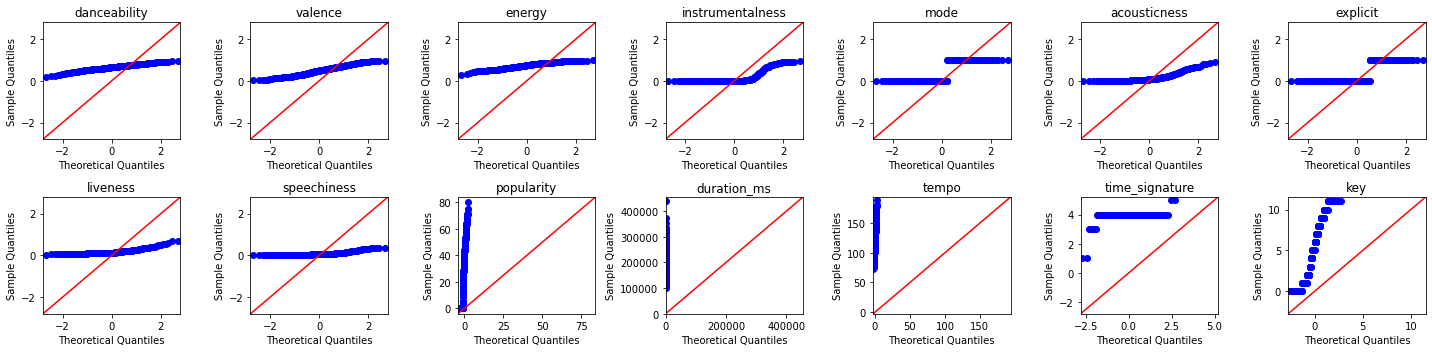

In [45]:
# Create Q-Q plot for each feature
fig = plt.figure(figsize=(20, 5))
for i, ifeature in enumerate(feature_ls):
    ax = fig.add_subplot(2, 7, i+1)
    ax.set_title(ifeature)
    sm.qqplot(
        playlist_dct["Your Top Songs 2019-2021"]["data_df"][ifeature],
        line='45',
        ax=ax
    )
fig.tight_layout()

The sample quantiles do not match the theoretical quantiles for any of the features, which means that they are not normally distributed. We can confirm this using the Shapiro-Wilk test:

In [46]:
s_ls = []
p_ls = []
b_ls = []

for ifeature in feature_ls:
    
    s, p = shapiro(
        playlist_dct["Your Top Songs 2019-2021"]["data_df"][ifeature]
    )
    s_ls.append(s)
    p_ls.append(p)
    
    if p < 0.02:
        b = False
    else:
        b = True
    b_ls.append(b)
    
shapiro_df = pd.DataFrame(
    zip(s_ls, p_ls, b_ls),
    index=feature_ls,
    columns=['statistic', 'p-value', 'normal']
)
shapiro_df.sort_values('p-value', ascending=False)

,statistic,p-value,normal
danceability,0.987638,1.657143e-02,False
valence,0.984124,3.305882e-03,False
tempo,0.980462,6.836899e-04,False
energy,0.973704,4.877761e-05,False
duration_ms,0.967155,5.004777e-06,False
key,0.925935,1.310615e-10,False
popularity,0.919992,4.008586e-11,False
liveness,0.812270,9.815805e-18,False
acousticness,0.750454,2.547669e-20,False
speechiness,0.709814,9.083032e-22,False


The p-values are all inferior to 0.02 and confirm that the features are not normally distributed.

Consequently, let's use a nonparametric test, and more specifically, the Mann-Whitney U test:

In [47]:
s_ls = []
p_ls = []
b_ls = []

for ifeature in feature_ls:
    
    s, p = mannwhitneyu(
        playlist_dct["Your Top Songs 2019-2021"]["data_df"][ifeature],
        playlist_dct["Today's Top Hits"]['data_df'][ifeature]
    )
    s_ls.append(s)
    p_ls.append(p)
    
    if p < 0.02:
        b = True
    else:
        b = False
        
    b_ls.append(b)
    
mwu_df = pd.DataFrame(
    zip(s_ls, p_ls, b_ls),
    index=feature_ls,
    columns=['statistic', 'p-value', 'significant']
)
mwu_df.sort_values('p-value', ascending=True)

,statistic,p-value,significant
popularity,372.0,5.991039e-33,True
instrumentalness,4533.0,5.233137e-10,True
duration_ms,5633.0,3.230739e-06,True
energy,5855.5,1.341331e-05,True
acousticness,6553.5,6.399832e-04,True
explicit,7001.5,7.727418e-04,True
mode,7447.5,1.109369e-02,True
danceability,7478.5,2.718565e-02,False
speechiness,7959.5,1.057165e-01,False
liveness,7987.0,1.129256e-01,False


Among other things, we see that song key is not actually a significant feature but that the mode is.

# Music recommendations based on identified audio feature preferences

Let's turn the gained insights about my audio feature preferences into a first simple recommendation system. We will order the Allmusic tracks from highest to lowest combined audio feature score ('recommend_score') that we define as:

recommend_score = energy + instrumentalness - acousticness

Note that we are not taking into account all identified significant features in our simple recommendation score, e.g., we do not consider popularity despite its highest found significance. Of course the global hits are per definition extremely popular, but that does not mean that I am looking for songs which are as least popular as possible. Regarding duration, I do not want to end up with recommended songs which are never ending. As for explicitness and mode of songs, these are binary values which would too heavily influence the recommendation score, i.e., we would end up with mostly non explicit songs in minor mode at the top of our recommendations, which would certainly not be a very useful recommendation system.

In [48]:
playlist_dct[f'Allmusic {week}']['data_df']['recommend_score'] = \
    playlist_dct[f'Allmusic {week}']['data_df']['energy'] + \
    playlist_dct[f'Allmusic {week}']['data_df']['instrumentalness'] - \
    playlist_dct[f'Allmusic {week}']['data_df']['acousticness']

playlist_dct[f'Allmusic {week}']['data_df'].sort_values(
    "recommend_score",
    ascending=False,
    inplace=True
)

Now let's create a new Spotify playlist and add the Allmusic tracks from highest to lowest recommendation score. Assuming that our first simple recommendation system does better than random sorting, we should find songs we like faster simply by listening to the playlist songs following their top to bottom order.

In [49]:
track_uri_ls = playlist_dct[f'Allmusic {week}']['data_df']['song_uri'].values.tolist()

playlist = spotify.playlist_create(
    user.id,
    f'Allmusic {week} Personalized A', # playlist name
    public=False,
    description=f"Allmusic's featured albums of week {week} sorted to maximize E+I-A."
)

track_uri_ls_ls = [track_uri_ls[x:x+100] for x in range(0, len(track_uri_ls), 100)]
for ils in track_uri_ls_ls:
    spotify.playlist_add(playlist.id, uris=ils)

Let's have a look at the songs which I should like most according to our first simple recommendation system:

In [50]:
playlist_dct[f'Allmusic {week}']['data_df'].reset_index(drop=True).head()

,release_date,duration_ms,artist_name,popularity,song_name,explicit,song_uri,song_id,instrumentalness,time_signature,...,acousticness,speechiness,loudness,liveness,valence,energy,tempo,mode,key,recommend_score
0,2022-01-14,164769,Nicfit,10,Boundary,0,spotify:track:6mTG0hNuMzlxAEU3zcBOuE,6mTG0hNuMzlxAEU3zcBOuE,0.892,4.0,...,0.000052,0.0832,-4.043,0.3810,0.3460,0.926,194.901,0.0,11.0,1.817948
1,2022-01-14,206746,Underoath,52,Take A Breath,0,spotify:track:2zNT8KqOqR0FXVBa9wBHEE,2zNT8KqOqR0FXVBa9wBHEE,0.806,4.0,...,0.000004,0.0442,-4.853,0.2100,0.3200,0.938,135.017,1.0,2.0,1.743996
2,2022-01-14,371520,Bonobo,63,Otomo,0,spotify:track:59QNyVtGhYoDnpO6T1e4yR,59QNyVtGhYoDnpO6T1e4yR,0.856,4.0,...,0.004090,0.0423,-8.930,0.1140,0.0392,0.841,125.994,0.0,4.0,1.692910
3,2022-01-14,201151,Nicfit,14,Human Inane,0,spotify:track:7e3QmMyyoJ5TUVdY8UPt4q,7e3QmMyyoJ5TUVdY8UPt4q,0.772,4.0,...,0.003540,0.0965,-4.767,0.1370,0.3490,0.892,124.869,1.0,7.0,1.660460
4,2022-01-10,180466,Ari Roar,18,Made to Never Use,0,spotify:track:7MG8cE1utun9mH8NdPCZCn,7MG8cE1utun9mH8NdPCZCn,0.780,4.0,...,0.002720,0.0342,-6.651,0.0818,0.6870,0.871,189.044,1.0,0.0,1.648280


A quick listen into my top song recommendation is not very promising: sounds like noise... and not the pleasant type.

However, the second and third songs are quite enjoyable to me — maybe this simple recommender in not so awful after all? We will find out later in this notebook.

And here are the songs which I should like least:

In [51]:
playlist_dct[f'Allmusic {week}']['data_df'].reset_index(drop=True).tail()

,release_date,duration_ms,artist_name,popularity,song_name,explicit,song_uri,song_id,instrumentalness,time_signature,...,acousticness,speechiness,loudness,liveness,valence,energy,tempo,mode,key,recommend_score
265,2022-01-14,228960,The Lumineers,57,ROLLERCOASTER,0,spotify:track:5jwgqsTNFsKQIMrwhGZ5et,5jwgqsTNFsKQIMrwhGZ5et,0.000867,4.0,...,0.975,0.0387,-12.188,0.0913,0.2200,0.1860,197.569,1.0,5.0,-0.788133
266,2022-01-14,165118,Grace Cummings,23,Here is the Rose,0,spotify:track:75YmYjGaHqsMdAjI5ZPQP5,75YmYjGaHqsMdAjI5ZPQP5,0.000023,4.0,...,0.906,0.0325,-13.373,0.1120,0.3190,0.0990,116.386,1.0,10.0,-0.806976
267,2021-11-19,144714,Soleá Morente,26,Enrique,0,spotify:track:3xXsDnX9hXJov7vfFrjEOm,3xXsDnX9hXJov7vfFrjEOm,0.051600,5.0,...,0.981,0.0344,-16.581,0.0814,0.0995,0.1180,90.515,0.0,2.0,-0.811400
268,2022-01-14,183245,Grace Cummings,23,Two Little Birds,0,spotify:track:06dlUBO8exedfg4Y0gckoq,06dlUBO8exedfg4Y0gckoq,0.002400,4.0,...,0.960,0.0504,-17.089,0.0633,0.2700,0.0995,123.710,1.0,7.0,-0.858100
269,2022-01-14,222040,Cat Power,52,A Pair Of Brown Eyes,0,spotify:track:0UarZjItL27xT9Dwh5aYeF,0UarZjItL27xT9Dwh5aYeF,0.000000,5.0,...,0.964,0.0387,-13.647,0.1020,0.1940,0.0837,127.580,1.0,7.0,-0.880300


No me gusta indeed!

# Identifying favored song types with machine learning

In this part, we will carry out a deeper analysis of our top songs with the aim of creating a recommender that is a bit more sophisticated than the previous one. Because surely, I must have songs I like which are not just of the type 'max(E+I-A)'.

We will use hierarchical clustering analysis to handle the many audio feature dimensions and identify song types (clusters) I like.

In [52]:
import scipy.cluster.hierarchy as hc
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering

### Hierarchical clustering analysis (HCA)

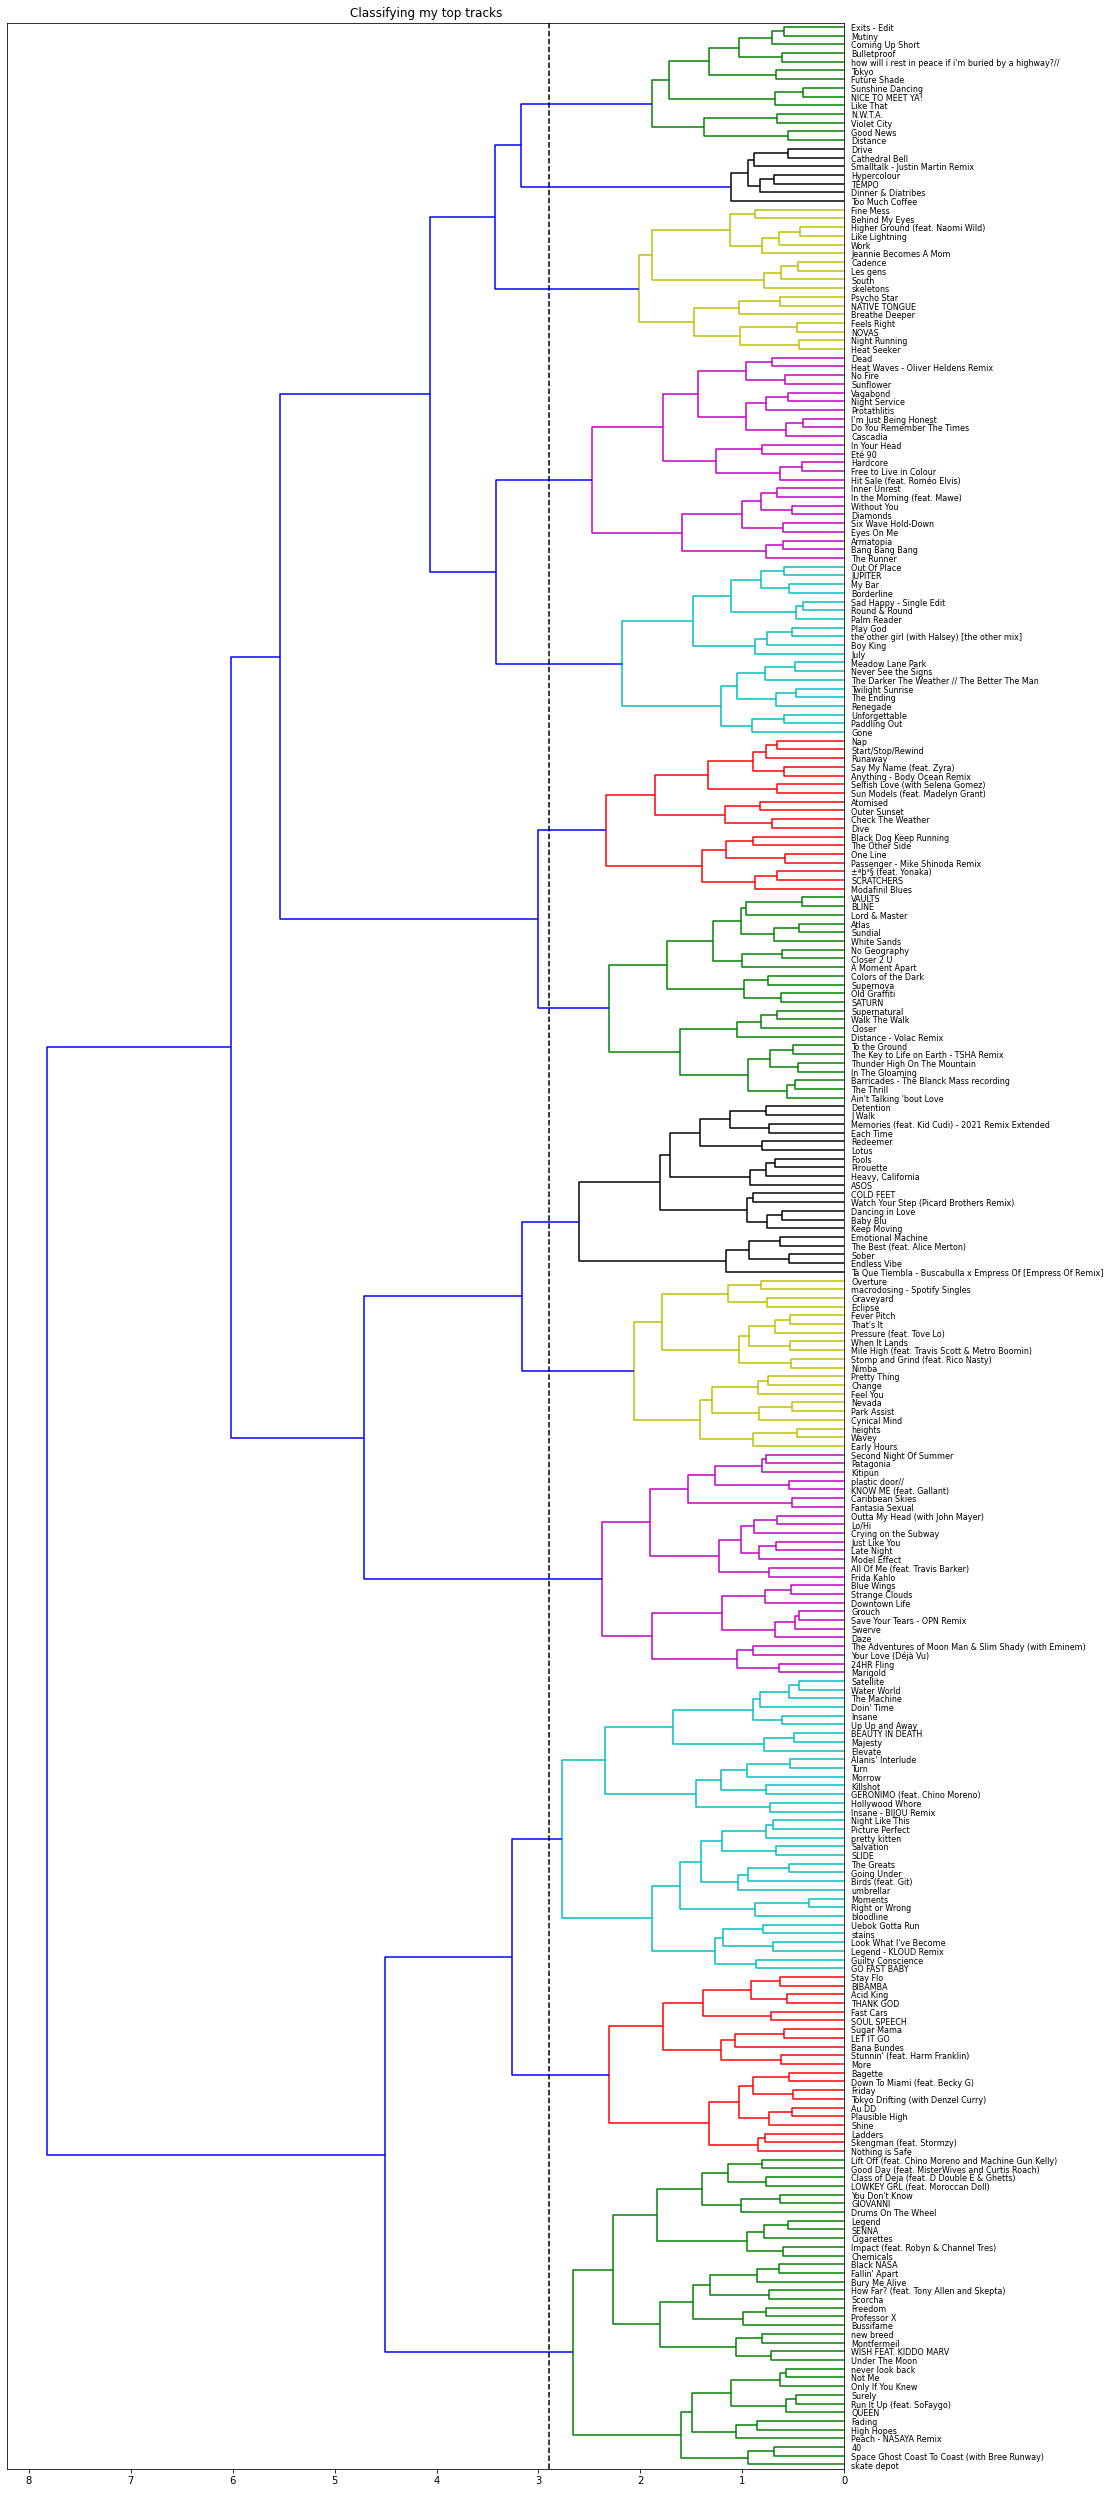

In [53]:
# We exclude some features from HCA
ftr_diff_ls = ["song_name", "artist_name", "song_id",
               "song_uri", "release_date", "popularity"]
ftr_select_ls = playlist_dct["Your Top Songs 2019-2021"]["data_df"].\
    columns.difference(ftr_diff_ls)
X = playlist_dct["Your Top Songs 2019-2021"]["data_df"][ftr_select_ls].values
# Scale and normalize data
sc = StandardScaler()
X_scal = sc.fit_transform(X)
X_norm = normalize(X_scal)
# Create dendrogram plot to visualize HCA results
threshold = 2.9  # value chosen after looking at the dendrogram
plt.figure(figsize=(15, 45))
plt.title('Classifying my top tracks')
songs = playlist_dct["Your Top Songs 2019-2021"]["data_df"]['song_name'].values
dendrogram = hc.dendrogram(
    (hc.linkage(X_norm, method='ward')),
    orientation='left',
    labels=songs,
    leaf_font_size=8,
    color_threshold=threshold
)
plt.axvline(x=threshold, color='black', linestyle='--')
plt.show()

'Cutting' the branches of the dendrogram at a distance of 3 generates 13 classes.

Let's label each song accordingly:

In [54]:
n_clusters = 13
agc = AgglomerativeClustering(n_clusters=n_clusters)
playlist_dct["Your Top Songs 2019-2021"]["data_df"]['class'] = \
    agc.fit_predict(X_norm)

In [55]:
# Let's look at the average feature values for each class
class_features_ls = [playlist_dct["Your Top Songs 2019-2021"]["data_df"]
                     [playlist_dct["Your Top Songs 2019-2021"]["data_df"]
                     ['class'] == iclass].describe().loc['mean', :]
                     for iclass in range(n_clusters)]
class_df = pd.concat(class_features_ls, axis=1)
playlist_dct["Your Top Songs 2019-2021"]['classes_df'] = class_df.transpose()
playlist_dct["Your Top Songs 2019-2021"]['classes_df'].set_index(
    'class',
    inplace=True
)
playlist_dct["Your Top Songs 2019-2021"]['classes_df']

,duration_ms,popularity,explicit,instrumentalness,time_signature,danceability,acousticness,speechiness,loudness,liveness,valence,energy,tempo,mode,key
class,,,,,,,,,,,,,,,
0.0,194782.676471,39.441176,0.970588,0.009770,4.000000,0.624471,0.099332,0.067865,-5.741559,0.144803,0.343815,0.730882,136.726235,0.323529,5.117647
1.0,216462.850000,33.000000,0.000000,0.029241,4.000000,0.725900,0.140527,0.051155,-7.234700,0.142800,0.567550,0.685650,116.933550,0.000000,5.550000
2.0,208385.888889,36.500000,0.833333,0.027326,4.000000,0.720750,0.183191,0.228936,-6.445194,0.217381,0.579694,0.724361,111.305667,0.444444,4.638889
3.0,204137.950000,27.850000,0.000000,0.010434,4.000000,0.619200,0.041485,0.039855,-4.813350,0.144705,0.656600,0.819650,107.479500,0.000000,8.300000
4.0,210497.884615,35.923077,0.000000,0.037488,4.000000,0.717885,0.136352,0.049446,-6.764769,0.143438,0.591538,0.692077,119.648808,1.000000,2.384615
5.0,271851.555556,35.833333,0.000000,0.416652,4.000000,0.577167,0.098103,0.056344,-9.144778,0.125728,0.385806,0.651333,111.550389,0.333333,7.222222
6.0,221705.125000,28.166667,0.000000,0.026057,4.000000,0.538375,0.040069,0.044267,-4.831875,0.116588,0.535208,0.847417,114.076542,0.875000,6.625000
7.0,231543.235294,38.294118,0.000000,0.056848,4.000000,0.587353,0.026141,0.078847,-4.823235,0.407529,0.519059,0.846176,111.765706,0.529412,5.176471
8.0,223918.500000,29.214286,0.000000,0.055478,4.000000,0.496786,0.028426,0.077243,-4.441571,0.172650,0.538786,0.801929,161.022214,0.357143,3.785714


Now let's visualize the average feature values of each class with a heatmap:

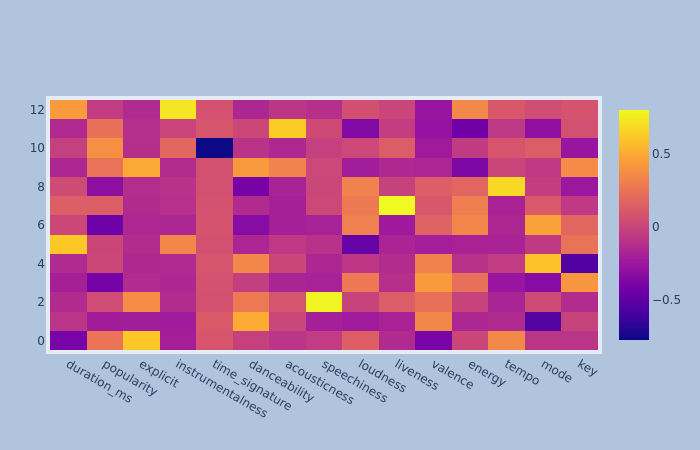

In [56]:
X = playlist_dct["Your Top Songs 2019-2021"]['classes_df'].values
# Scale and normalize data
sc = StandardScaler()
X_scal = sc.fit_transform(X)
X_norm = normalize(X_scal)
# Heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(
    y=playlist_dct["Your Top Songs 2019-2021"]['classes_df'].index.values,
    x=playlist_dct["Your Top Songs 2019-2021"]['classes_df'].columns.values,
    z=X_norm
))
fig.update_layout(
    autosize=False,
    width=600, height=600,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor="LightSteelBlue",
)
# Static version of the heatmap
fig.show("png")

Looking at the average feature values for the classes and which songs they are comprised of, we come up with representative names for each:

In [57]:
classes_dct = {0:'Cool', 1:'Dancy', 2:'Verböse', 3:'Euphoric', 4:'Easy',
               5:'Melodic', 6:'Punchy', 7:'Engaging', 8:'Pacy',
               9:'E-Room', 10:'Odd', 11:'Candid', 12:'Driving'}

About the classes and the chosen names:

0: Songs which are explicit, loud, fast and not so jolly, are songs I typically find cool.

1: Songs with high danceability -> dancy.

2: Songs in this class have a high speechiness and explicitness, I call this class 'Verböse' as a mix of verbose (wordy) & böse (German for nasty).

3: Loud, happy & energetic songs -> euphoric.

4: Relatively short and dancy songs in common major low keys make for an easy listen.

5: Relatively long songs with high instrumentalness but not very loud and energetic tend to be quite melodic.

6: Loud and energetic songs in mostly bright major mode often pack a punch.

7: High liveness make for an engaging song experience.

8: High tempo -> pacy songs.

9: Looking at the features, I couldn't come up with a good name, so I looked at the predominant genre in this class: Escape Room.

10: Time signature of 3 -> odd.

11: High acousticness, melancholic and calm, in minor mode -> candid songs.

12: Relatively long songs with high instrumentalness and energy tend to be highly driving.

Replot the heat map but using the made up class names:

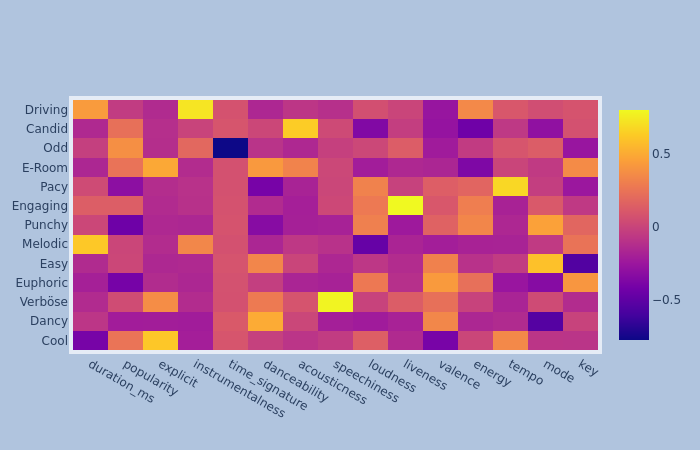

In [58]:
fig = go.Figure()
fig.add_trace(go.Heatmap(
    y=list(classes_dct.values()),
    x=playlist_dct["Your Top Songs 2019-2021"]['classes_df'].columns.values,
    z=X_norm)
)
fig.update_layout(
    autosize=False,
    width=600, height=600,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor="LightSteelBlue",
)
# Static version of the heatmap
fig.show("png")

# Music recommendations based on distance to identified clusters

Now that we have gained deeper insights into my music preferences, we are ready to introduce a new recommendation system.

We will compute the distances between the Allmusic songs and the identified classes. The recommended songs will then be the songs with the smallest class distances.

In [59]:
import numpy as np
from scipy.spatial.distance import cdist

### Compute Euclidian distances between Allmusic songs and my classes

In [60]:
X_classes = playlist_dct["Your Top Songs 2019-2021"]['classes_df'].values
columns = playlist_dct["Your Top Songs 2019-2021"]['classes_df'].columns
X_new = playlist_dct[f"Allmusic {week}"]['data_df'][columns].values
X = np.concatenate((X_classes, X_new))
# Scale and normalize data
sc = StandardScaler()
X_scal = sc.fit_transform(X)
X_norm = normalize(X_scal)
X_classes_norm = X_norm[:len(X_classes)]
X_new_norm = X_norm[len(X_classes):]
# Compute Euclidian distances to classes
dist_classes = cdist(X_new_norm, X_classes_norm)
songs = playlist_dct[f"Allmusic {week}"]['data_df']['song_name'].values
dist_classes_df = pd.DataFrame(
    data=dist_classes,
    index=songs,
    columns=list(classes_dct.values())
)
dist_classes_df.head()

,Cool,Dancy,Verböse,Euphoric,Easy,Melodic,Punchy,Engaging,Pacy,E-Room,Odd,Candid,Driving
Boundary,1.381680,1.453848,1.443182,1.272824,1.669522,1.304876,1.349849,1.193620,1.010801,1.535421,1.372148,1.451121,1.024028
Take A Breath,1.385572,1.477919,1.464663,1.425647,1.195011,1.290884,1.159487,1.147212,1.114705,1.599341,1.223138,1.643578,0.788426
Otomo,1.306603,1.169868,1.426602,1.290955,1.389920,0.731847,1.387205,1.313437,1.273885,1.363036,1.256101,1.177271,0.731274
Human Inane,1.438026,1.516426,1.366382,1.315732,1.411532,1.197786,1.025865,1.274387,1.134728,1.577728,1.361185,1.641963,0.876859
Made to Never Use,1.374967,1.389532,1.478573,1.383592,1.103977,1.409370,1.162081,1.395040,0.893614,1.573226,1.320921,1.661842,1.044537


### Compute Euclidian distances between Allmusic songs and my top songs

In [61]:
X_top = playlist_dct["Your Top Songs 2019-2021"]['data_df'][columns].values
X = np.concatenate((X_top, X_new))
# Scale and normalize data
sc = StandardScaler()
X_scal = sc.fit_transform(X)
X_norm = normalize(X_scal)
X_top_norm = X_norm[:len(X_top)]
X_new_norm = X_norm[len(X_top):]
# Compute Euclidian distances to classes
dist_top = cdist(X_new_norm, X_top_norm)
songs = playlist_dct["Your Top Songs 2019-2021"]['data_df']['song_name'].values
dist_top_df = pd.DataFrame(
    data=dist_top,
    index=playlist_dct[f"Allmusic {week}"]['data_df']['song_name'].values,
    columns=songs)
dist_top_df.head()

,Going Under,Each Time,Feel You,Park Assist,Marigold,Nimba,Right or Wrong,Plausible High,Birds (feat. Git),South,...,Professor X,Fine Mess,Bulletproof,bloodline,Night Running,Lift Off (feat. Chino Moreno and Machine Gun Kelly),You Don't Know,Without You,Freedom,No Geography
Boundary,1.436948,1.632368,1.418221,1.578773,1.734602,1.617998,1.456032,1.635731,1.490558,1.203311,...,1.673747,0.904780,1.031098,1.513640,1.153368,1.556426,1.650482,1.390637,1.553766,1.079980
Take A Breath,1.422453,1.757741,1.571295,1.685263,1.444439,1.717502,1.545033,1.736546,1.370145,1.367854,...,1.422679,0.875085,1.228784,1.441193,1.185787,1.575463,1.530277,1.101021,1.477888,0.816396
Otomo,1.405956,1.382593,1.520103,1.259458,1.431940,1.502782,1.626253,1.307862,1.495135,1.518259,...,1.463590,1.440052,1.430465,1.364355,1.347981,1.489320,1.401310,1.547290,1.516451,0.913913
Human Inane,1.593783,1.739340,1.688384,1.698464,1.715630,1.646106,1.607967,1.752620,1.573143,1.249401,...,1.665774,0.852697,1.252871,1.726297,1.466166,1.378170,1.584351,1.079859,1.532429,1.050568
Made to Never Use,1.314903,1.616402,1.345278,1.890860,1.396468,1.483696,1.196164,1.740718,1.257008,1.505152,...,1.489318,1.023511,1.198456,1.393991,1.347175,1.736306,1.561060,0.897386,1.307276,1.109902


### Order Allmusic songs from smallest to largest distance to classes & also indicate closest song

In [62]:
closest_classes = dist_classes_df.idxmin(axis=1).values
class_dist = dist_classes_df.min(axis=1).values
playlist_dct[f"Allmusic {week}"]['data_df']['class_name'] = closest_classes
playlist_dct[f"Allmusic {week}"]['data_df']['class_distance'] = class_dist
closest_song = dist_top_df.idxmin(axis=1).values
song_dist = dist_top_df.min(axis=1).values
playlist_dct[f"Allmusic {week}"]['data_df']['song_sim'] = closest_song
playlist_dct[f"Allmusic {week}"]['data_df']['song_dist'] = song_dist
playlist_dct[f"Allmusic {week}"]['data_df'].sort_values(
    'class_distance',
    inplace=True
)

### Create Spotify playlist & add Allmusic songs from most to least recommended

In [63]:
track_uri_ls = playlist_dct[f'Allmusic {week}']['data_df']['song_uri'].values.tolist()

playlist = spotify.playlist_create(
    user.id,
    f'Allmusic {week} Personalized B', # playlist name
    public=False,
    description=f"Allmusic's featured albums of week {week} sorted to minimize distance to favored song types."
)

track_uri_ls_ls = [track_uri_ls[x:x+100] for x in range(0, len(track_uri_ls), 100)]
for ils in track_uri_ls_ls:
    spotify.playlist_add(playlist.id, uris=ils)

Let's have a look at our top recommendations:

In [64]:
column_ls = ["song_name", "artist_name", "class_name",
             "class_distance", "song_sim", "song_dist"]
df = playlist_dct[f"Allmusic {week}"]['data_df'].copy()
df[column_ls].reset_index(drop=True).head()

,song_name,artist_name,class_name,class_distance,song_sim,song_dist
0,2010,Earl Sweatshirt,Verböse,0.336554,Run It Up (feat. SoFaygo),0.471153
1,Glow,Fickle Friends,Easy,0.359011,Lo/Hi,0.508062
2,Lobby (int),Earl Sweatshirt,Verböse,0.434006,Run It Up (feat. SoFaygo),0.379300
3,Titanic,Earl Sweatshirt,Verböse,0.437750,QUEEN,0.552382
4,Fill Your Cup,Garcia Peoples,Pacy,0.488683,how will i rest in peace if i'm buried by a hi...,0.730502


Quick listen into the first two top recommendations and the verdict is: love them!

Seems our AI assistant is doing a pretty good job. Let's evaluate its performance more thoroughly in the next part.

By the way, even if AI assistants like these are great, I do not encourage the use of Allmusic through web scraping only and I highly recommend visiting this wonderful website through a browser without ad blocking. 

I very much enjoy to read what the reviewers have to say about the albums and songs, e.g.:

"'2010' is a psychedelic sprawl of nostalgia" Fred Thomas

"'Glow' has a funky, polyester-toned kineticism that brings to mind Prince" Matt Collar

You can just skip the reviews for the least recommended music:

In [65]:
df[column_ls].reset_index(drop=True).tail()

,song_name,artist_name,class_name,class_distance,song_sim,song_dist
265,Storm Queen,Grace Cummings,Candid,1.516008,Park Assist,1.020685
266,Atlas,Daniel Blumberg,Candid,1.559412,Overture,0.902868
267,Love and Death,Daniel Blumberg,Melodic,1.571362,Overture,0.867171
268,First Kiss,Daniel Blumberg,Candid,1.598697,Overture,0.678978
269,The Wagon,Daniel Blumberg,Candid,1.603853,Overture,0.804323


... haven't yawned that hard in a while. I look forward for my AI music assistant to spare my ears in the future from such buzzkills.

# Comparing recommenders: A vs B

Now comes the interesting part of evaluating and comparing the performance of our recommender!

We will label the first simple recommender as 'A' and the second slightly more sophisticated one as 'B'.

In [66]:
import torch
from scipy.optimize import curve_fit

### Get my Allmusic song favorites

In order to compare performances, I first need to go through all the Allmusic songs sonically and save the ones I like to a new playlist.

In [67]:
total_song_nr = len(playlist_dct[f'Allmusic {week}']['data_df'])
playlist_likes = f'Allmusic {week} Liked'
print((f"Go to Spotify playlist '{f'Allmusic {week}'}' created earlier,"
       f" listen to the {total_song_nr} songs and manually "
       f"add favorites to new playlist '{playlist_likes}'."))

Go to Spotify playlist 'Allmusic 20220114' created earlier, listen to the 270 songs and manually add favorites to new playlist 'Allmusic 20220114 Liked'.


In [68]:
# Get playlist with liked songs
playlist_name, track_df = find_fetch_playlist(playlist_likes)
playlist_dct[playlist_name] = {}
playlist_dct[playlist_name]['data_df'] = track_df
playlist_dct[playlist_name]['stats_df'] = track_df.describe()
# Let's have a look at some statistics from the liked songs
playlist_dct[playlist_name]['stats_df']

Fetching tracks incl. info & audio features from the playlist 'Allmusic 20220114 Liked'


,duration_ms,popularity,explicit,instrumentalness,time_signature,danceability,acousticness,speechiness,loudness,liveness,valence,energy,tempo,mode,key
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,215191.393443,51.295082,0.180328,0.233447,3.983607,0.600885,0.104393,0.067648,-7.124311,0.198574,0.564193,0.749426,124.791443,0.540984,5.688525
std,57285.123702,20.257792,0.387651,0.346144,0.128037,0.126945,0.185547,0.081387,1.929032,0.166700,0.218102,0.139419,24.536510,0.502453,3.783918
min,96240.000000,14.000000,0.000000,0.000000,3.000000,0.280000,0.000004,0.024700,-15.533000,0.049800,0.039200,0.314000,80.013000,0.000000,0.000000
25%,184251.000000,39.000000,0.000000,0.000037,4.000000,0.514000,0.002880,0.034200,-7.927000,0.090100,0.437000,0.681000,109.946000,0.000000,2.000000
50%,205469.000000,51.000000,0.000000,0.002480,4.000000,0.592000,0.029600,0.041900,-7.003000,0.134000,0.620000,0.761000,123.006000,1.000000,6.000000
75%,233056.000000,63.000000,0.000000,0.485000,4.000000,0.689000,0.103000,0.055200,-5.692000,0.290000,0.729000,0.853000,135.017000,1.000000,9.000000
max,452596.000000,93.000000,1.000000,0.932000,4.000000,0.888000,0.791000,0.390000,-4.051000,0.965000,0.905000,0.959000,189.044000,1.000000,11.000000


We can see that on average the liked songs have a high energy (>0.7), matching the previous insights about my taste. Surprisingly though, I picked more songs with major rather than minor keys.

In [69]:
# In the full list of Allmusic songs, label the liked ones with 1 and...
# ...the others with 0 using a lambda function
playlist_dct[f'Allmusic {week}']['data_df']['like'] = \
    playlist_dct[f'Allmusic {week}']['data_df'].apply(
        lambda x: 1 if x.song_id in
        playlist_dct[playlist_likes]['data_df']['song_id'].values
        else 0,
        axis=1
    )

In [70]:
total_like_nr = playlist_dct[f'Allmusic {week}']['data_df']['like'].sum()
print((f"I like {total_like_nr} songs from the"
       f" total number of {total_song_nr}."))

I like 61 songs from the total number of 270.


In [71]:
# Playlists with song order from respective recommender
B_df = playlist_dct[f'Allmusic {week}']['data_df'].copy()
A_df = B_df.sort_values('recommend_score', ascending=False).copy()
# Playlist with randomized song order as control
R_df = playlist_dct[f'Allmusic {week}']['data_df'].copy().sample(frac=1)

### Plotting: A vs B recommender performance

In [72]:
# We build axes for plotting using list comprehensions
x_ls = [(x+1)/total_song_nr*100 for x in range(total_song_nr)]  # x-axis
y_A_ls = [A_df['like'].iloc[:i].sum()/total_like_nr*100
          for i in range(total_song_nr)]
y_B_ls = [B_df['like'].iloc[:i].sum()/total_like_nr*100
          for i in range(total_song_nr)]
# Randomized y-axis values as control / baseline
y_R_ls = [R_df['like'].iloc[:i].sum()/total_like_nr*100
          for i in range(total_song_nr)]

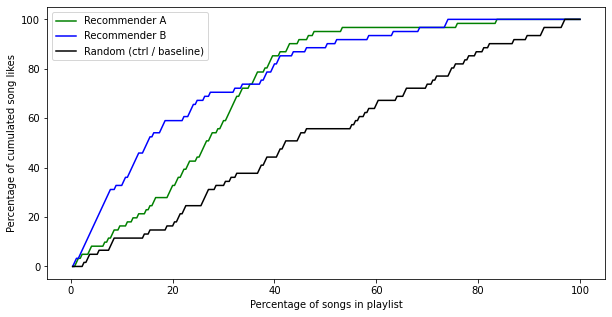

In [73]:
# Create plot using Matplotlib
fig = plt.figure(figsize=(10, 5))
plt.plot(x_ls, y_A_ls, label='Recommender A', color='green')
plt.plot(x_ls, y_B_ls, label='Recommender B', color='blue')
plt.plot(x_ls, y_R_ls, label='Random (ctrl / baseline)', color='black')
plt.xlabel('Percentage of songs in playlist')
plt.ylabel('Percentage of cumulated song likes')
plt.legend()
plt.show()

We see that both personalized recommenders perform better than the random one — that's reassuring!

We also see that overall, recommender B outperforms recommender A — the extra effort payed!

In [74]:
A_half = round(x_ls[np.abs(np.array(y_A_ls)-50).argmin()])
B_half = round(x_ls[np.abs(np.array(y_B_ls)-50).argmin()])
print((f"With recommender B we only need to go through {B_half}% of the "
       "playlist to find half of the songs we like, whereas with recommender"
       f" A we need to go through {A_half}% of the playlist."))

With recommender B we only need to go through 15% of the playlist to find half of the songs we like, whereas with recommender A we need to go through 26% of the playlist.


However, recommender B catches up to recommender A at some point due to a slope increase for A and decrease for B around 20%. The higher the slope, the better the recommender performance, so it would be interesting to plot the slope values. To do this, we first need to fit the curves and then get their derivatives. Curve A looks logarithmic while curve B looks sigmoidal, so let's fit accordingly.

In [75]:
# Define general sigmoidal function to fit curve A
def sigm_fn(x, a, b, c, d):
    return a / (1 + np.exp(-b*(x-c))) + d


# Define general logarithmic function to fit curve B
def log_fn(x, a, b, c, d):
    return a * np.log(b*x+c) + d


# Define general linear function to fit random curve
def lin_fn(x, a, b):
    return a*x + b

In [78]:
# Fit curve A
p0_A = [100, 1, 50, 1]  # initial guess
popt_A, pcov_A = curve_fit(sigm_fn, x_ls, y_A_ls, p0_A)
print(f'Optimized sigmoidal fit parameters for curve A: {popt_A}')
# Fit curve B
p0_B = [30, 1, 1, -30]  # initial guess
popt_B, pcov_B = curve_fit(log_fn, np.array(x_ls), np.array(y_B_ls), p0_B)
print(f'Optimized logarithmic fit parameters for curve B: {popt_B}')
# Fit random curve
p0_R = [1, 1]  # initial guess
popt_R, pcov_R = curve_fit(lin_fn, np.array(x_ls), np.array(y_R_ls))
print(f'Optimized linear fit parameters for random curve: {popt_R}')

Optimized sigmoidal fit parameters for curve A: [97.67745666  0.12005666 26.26035717  1.41152134]
Optimized logarithmic fit parameters for curve B: [ 31.73591567   0.95881981   2.1259134  -38.66721052]
Optimized linear fit parameters for random curve: [1.04934854 0.64729609]


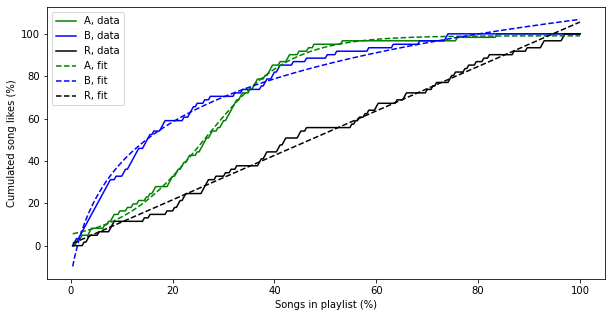

In [79]:
# Plot curves & their fitted functions
fig = plt.figure(figsize=(10, 5))

plt.plot(x_ls, y_A_ls, label='A, data', color='green')
plt.plot(x_ls, y_B_ls, label='B, data', color='blue')
plt.plot(x_ls, y_R_ls, label='R, data', color='black')
plt.plot(
    np.array(x_ls),
    sigm_fn(np.array(x_ls), *popt_A),
    '--',
    label='A, fit',
    color='green'
)
plt.plot(
    np.array(x_ls),
    log_fn(np.array(x_ls), *popt_B),
    '--',
    label='B, fit',
    color='blue'
)
plt.plot(
    np.array(x_ls),
    lin_fn(np.array(x_ls), *popt_R),
    '--',
    label='R, fit',
    color='black'
)
plt.xlabel('Songs in playlist (%)')
plt.ylabel('Cumulated song likes (%)')
plt.legend()
plt.show()

The fits look good, let's calculate their derivatives with PyTorch and plot the results.

In [80]:
# Calculate derivative of the sigmoidal function
x = torch.tensor(x_ls, requires_grad=True)
a, b, c, d = popt_A
Y_A = a / (1 + torch.exp(-b*(x-c))) + d
y_A = torch.sum(Y_A)
y_A.backward()
y_grad_A = x.grad.detach().numpy()

In [81]:
# Calculate derivative of the logarithmic function
x = torch.tensor(x_ls, requires_grad=True)
a, b, c, d = popt_B
Y_B = a * torch.log(b*x+c) + d
y_B = torch.sum(Y_B)
y_B.backward()
y_grad_B = x.grad.detach().numpy()

In [82]:
# Calculate derivative of the logarithmic function
x = torch.tensor(x_ls, requires_grad=True)
a, b = popt_R
Y_R = a * x + b
y_R = torch.sum(Y_R)
y_R.backward()
y_grad_R = x.grad.detach().numpy()

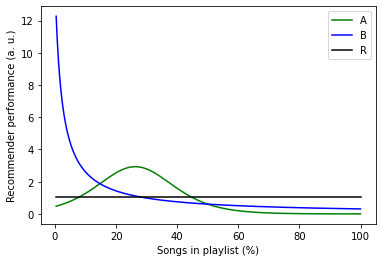

In [83]:
# Plot the derivatives
plt.plot(x_ls, y_grad_A, label='A', color='green')
plt.plot(x_ls, y_grad_B, label='B', color='blue')
plt.plot(x_ls, y_grad_R, label='R', color='black')
plt.xlabel('Songs in playlist (%)')
plt.ylabel('Recommender performance (a. u.)')
plt.legend()
plt.show()

We see that while recommender B kicks off all guns blazing, recommender A only gets into gears after initially misfiring.

In [84]:
ix_AR_catch = np.abs(
    y_grad_A[:round(total_song_nr/3)]-y_grad_R[:round(total_song_nr/3)]
)
ix_AR_catch = ix_AR_catch.argmin()
ix_AB_catch = np.abs(
    y_grad_A[:round(total_song_nr/3)]-y_grad_B[:round(total_song_nr/3)]
)
ix_AB_catch = ix_AB_catch.argmin()
AR_catch = round(x_ls[ix_AR_catch])
AB_catch = round(x_ls[ix_AB_catch])
A_peak = round(x_ls[y_grad_A.argmax()])
print((f"At peak recommender A outpermorms the random"
       f" recommender by ~{round(y_grad_A.max())}x."))
print((f"At peak recommender B outpermorms the random"
       f" recommender by ~{round(y_grad_B.max())}x."))
print(f"Recommender A performs worse than than the random"
      f" recommender until {AR_catch}% of the playlist.")
print(f"Recommender A reaches peak performance around {A_peak}%.")
print((f"Recommender A performance catches up with recommender"
       f" B performance around {AB_catch}% of the playlist."))

At peak recommender A outpermorms the random recommender by ~3x.
At peak recommender B outpermorms the random recommender by ~12x.
Recommender A performs worse than than the random recommender until 8% of the playlist.
Recommender A reaches peak performance around 26%.
Recommender A performance catches up with recommender B performance around 15% of the playlist.


Based on these results, we choose to only recommend the top 15% songs of recommender B.

In [85]:
# Create df with only the final recommendations
recommend_song_nr = ix_AB_catch
recommendations_df = B_df.iloc[:recommend_song_nr].copy()
column_ls = ["song_name", "artist_name", "class_name", "song_sim"]
recommendations_df[column_ls].reset_index(drop=True).head()

,song_name,artist_name,class_name,song_sim
0,2010,Earl Sweatshirt,Verböse,Run It Up (feat. SoFaygo)
1,Glow,Fickle Friends,Easy,Lo/Hi
2,Lobby (int),Earl Sweatshirt,Verböse,Run It Up (feat. SoFaygo)
3,Titanic,Earl Sweatshirt,Verböse,QUEEN
4,Fill Your Cup,Garcia Peoples,Pacy,how will i rest in peace if i'm buried by a hi...


In [86]:
liked_recommendations = B_df.iloc[:recommend_song_nr]['like'].sum()
recommend_success = round(100*(liked_recommendations/recommend_song_nr))
print((f"Out of the {total_song_nr} Allmusic songs of week {week},"
       f" we recommend {recommend_song_nr} of them. "
       f"We expect that you will like ~{recommend_success}% of the songs."
       " You're welcome."))

Out of the 270 Allmusic songs of week 20220114, we recommend 39 of them. We expect that you will like ~77% of the songs. You're welcome.


In [87]:
liked_songs = B_df['like'].sum()
missed_song_likes = liked_songs - liked_recommendations
print((f"But what about the {missed_song_likes} songs we would "
       "also like but are not including in the recommendations?"))

But what about the 31 songs we would also like but are not including in the recommendations?


Well let's see if we are at least capturing most of the artists' albums. If so, then we can later easily find more of the songs we would like by looking into the artists' albums if the songs from them are really convincing and leave us wanting more.

In [88]:
recommend_artists = set(recommendations_df['artist_name'].values.tolist())
df = playlist_dct[f'Allmusic {week}']['data_df'].copy()
all_artists = set(df.loc[df['like'] == 1]['artist_name'].values.tolist())
missed_artists = all_artists - recommend_artists
print((f"We are only missing {len(missed_artists)}"
       f" artist(s): {missed_artists}. Oh well."))

We are only missing 1 artist(s): {'Ari Roar'}. Oh well.


# Conclusion

We have built two simple recommenders, with one slightly more sophisticated than the other.

The performance is already convincing enough to provide a useful personal AI music assistant to save time and find more songs to enjoy.

However, from here, there are many ideas and additional sophistications that can easily be implemented to improve our AI music assistant.

Maybe I'll update this notebook later in the future if there is interest.

I hope you enjoyed this little project and learned useful things for your projects.